In [24]:
import os
import torch
from torch import nn
import numpy as np
import random
from dataset import ModelnetDataset
from pathlib import Path
from torch.utils.data import DataLoader


from util import setup_seed, train, test, train_HHN, test_HHN, train_one4one, transform_angles, count_parameters, save_checkpoint
from model import One4All, HyperNetwork
from render import PointcloudRender
from tqdm import tqdm

from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene
import plotly.graph_objects as go
import plotly.express as px
from scipy.spatial import Delaunay
import time
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

from matplotlib.ticker import FormatStrFormatter
import pickle

## Init dataset

In [2]:
%matplotlib inline

In [3]:
setup_seed(666)
device_for_dataset = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
path = Path("./data/ModelNet10")
test_ds = ModelnetDataset(path, folder="test", device=device_for_dataset) # Just put dataset in mem or GPU
classes = {i: cat for cat, i in test_ds.classes.items()}

print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(test_ds.classes))

Preocessing test data in_mem = True and infor: Default infor


Prepare test dataset categories: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

Test dataset size:  908
Number of classes:  10


In [5]:
from collections import Counter
# print(dict(Counter(sample['category'] for sample in train_ds.files)))

print(dict(Counter(sample['category'] for sample in test_ds.files)))


{'bathtub': 50, 'bed': 100, 'chair': 100, 'desk': 86, 'dresser': 86, 'monitor': 100, 'night_stand': 86, 'sofa': 100, 'table': 100, 'toilet': 100}


In [6]:
batch_size = 256
step = 10

In [7]:
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [8]:
checkpoints_path = {
    3: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_3-HHNcheckpoint.pth.tar',
    6: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_6-HHNcheckpoint.pth.tar',
    16: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_16-HHNcheckpoint.pth.tar',
    32: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_32-HHNcheckpoint.pth.tar',
    1: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_1-HHNcheckpoint.pth.tar',
    2: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_2-HHNcheckpoint.pth.tar',
    5: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_5-HHNcheckpoint.pth.tar',
    8: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_8-HHNcheckpoint.pth.tar',
    
} 

In [9]:
gpu_computation = device_for_dataset


pr = PointcloudRender(              
                 img_size=128,
                 radius=0.0045,
                 points_per_pixel=40,
                 num_points = 4096)


loss_fn = nn.CrossEntropyLoss()


## Define the function for getting hyper_output

In [11]:
def evaluate_HNN_hyper_out(model, hyper_output_path, fixed_channel):
    torch.cuda.empty_cache()
    
    step_x = step
    step_y = step
    step_z = step
    if fixed_channel:
        if fixed_channel.lower() == "x":
            step_x = 360
        elif fixed_channel.lower() == "y":
            step_y = 360
        elif fixed_channel.lower() == "z":
            step_z = 360
        else:
            raise ValueError(f"incorrect fixed_channel: {fixed_channel}")

    HyperOutput = torch.tensor([]).to(device=gpu_computation)

    with tqdm(range(-180, 181, step_x), position=0) as t:
        for x in t:
            for y in tqdm(range(-180, 181, step_y), disable=True):
                for z in tqdm(range(-180, 181, step_z), disable=True):
                    t.set_description(f'Generate HHN hyper_out')
                    
                    angles = torch.tensor([x,y,z])/180*torch.pi
                    # t1 = time.time()
                    hyper_x = transform_angles(angles=angles).to(device=gpu_computation)
                    hyper_output = model.hyper_stack(hyper_x).detach()

                    hyper_output_with_angles = torch.cat((hyper_output, torch.tensor([x,y,z]).to(gpu_computation)), 0) # with angles
                    hyper_output_with_angles = torch.unsqueeze(hyper_output_with_angles,0)

                    HyperOutput = torch.cat((HyperOutput, hyper_output_with_angles), 0)

                    # t2 = time.time()
                    # print(f'runtime: {t2-t1:>.4}s')
                t.set_postfix(Angles = [x,y,z]) 
                    
    HyperOutput = HyperOutput.cpu().numpy()
    np.save(hyper_output_path, HyperOutput) # D = 1, 2, 3, 5, 6, 8, 16, 32


### Generate hyper_output

In [11]:
for fixed_angle in ['x', 'y', 'z', None]:
    for dimension in [1, 2, 3, 5, 6, 8, 16, 32]:
        model = HyperNetwork(dimension)
        model = model.to(gpu_computation)

        checkpoint = torch.load(checkpoints_path[dimension], map_location=gpu_computation)
        model.load_state_dict(checkpoint['state_dict'])
        if fixed_angle:
            hyper_output_path = f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{dimension}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_fixed_{fixed_angle}.npy'
        else:
            hyper_output_path = f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{dimension}_X_step{step}_Y_step{step}_Z_step{step}_with_angles.npy'
            
        print(hyper_output_path)
        evaluate_HNN_hyper_out(model, hyper_output_path, fixed_channel=fixed_angle)

./accuracy_result_npy/LeNet5/HHN_hyperout_d_1_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_2_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_3_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_5_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_6_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_8_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_16_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_32_X_step10_Y_step10_Z_step10_with_angles_fixed_x.npy


Generate HHN hyper_out: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_1_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 13.00it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_2_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 13.81it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_3_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 12.91it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_5_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_6_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 13.03it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_8_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 14.30it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_16_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 13.95it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_32_X_step10_Y_step10_Z_step10_with_angles_fixed_y.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:02<00:00, 14.40it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_1_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.70it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_2_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.49it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_3_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.81it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_5_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.78it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_6_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.75it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_8_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.85it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_16_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00,  9.82it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_32_X_step10_Y_step10_Z_step10_with_angles_fixed_z.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:03<00:00, 10.24it/s, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_1_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:50<00:00,  1.38s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_2_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:50<00:00,  1.36s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_3_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:51<00:00,  1.40s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_5_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:50<00:00,  1.35s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_6_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:50<00:00,  1.36s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_8_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:55<00:00,  1.49s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_16_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:53<00:00,  1.44s/it, Angles=[180, 180, 180]] 


./accuracy_result_npy/LeNet5/HHN_hyperout_d_32_X_step10_Y_step10_Z_step10_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it, Angles=[180, 180, 180]] 


## Define the funtion for drawing the pure beta space without alpha (Not used in final paper)

In [26]:
def draw_beta_space(hyper_output, dimension=3, display_channels=[0,1,2], threshold=0.08, filename="plots/beta.html", show = False):
    assert len( display_channels)==3, "Wrong numbder of channels. You should only draw 3D chart"
    


    distance_computation_channels = list(set(range(dimension)) ^ set(display_channels))
    print(distance_computation_channels)
    Beta = hyper_output
    beta_selected = []

    Beta_distance_computation_channels_mean = Beta[:, distance_computation_channels].mean(axis=0)
    Beta_distance_computation_channels_var = Beta[:, distance_computation_channels].var(axis=0)
    print(f'mean: {Beta_distance_computation_channels_mean}  var: {Beta_distance_computation_channels_var}')
    
    num_Beta = len(Beta)
    for i, beta in enumerate(Beta):
         # Take L2-norm as the distance metric, and select 3 dimensions of Beta for drawing and 2 dimensions for computing distance. 
        if np.linalg.norm(beta[distance_computation_channels]-Beta_distance_computation_channels_mean)<=threshold:
            beta_selected.append(beta)

    beta_selected  = np.array(beta_selected)
    num_beta_selected =len(beta_selected)
    print(f'With threshold={threshold}, select {num_beta_selected} of {num_Beta}')

    # df_column_names = [f'Beta{i}' for i in range(dimension) ]
    # beta_selected_df = pd.DataFrame(beta_selected  ,columns=df_column_names)

    # Only vaild for test D=3 #
    # my_color_group=[]
    # for y in range(-180, 180, 1):
    #     for z in range(-180,180,1):
    #         if y>=-180 and y<-90:
    #             my_color_group.append('red')
    #         elif y>=-90 and y<0:
    #             my_color_group.append('yellow')
    #         elif y>=0 and y<90:
    #             my_color_group.append('blue')
    #         elif y>=9 and y<180:
    #             my_color_group.append('green')

    # Only vaild for test D=3 #



    layout = go.Layout(
        # Figure size ration will be ignored 
        # width=600,
        # height=400,
        # Reduce default (rather big) margins between Figure edges and axes
        margin=go.layout.Margin(l=30,r=30,t=30,b=30),
        title=f"Beta space of HHN-D{dimension} on 3D rotation", # figure title
        font=dict(size=11),
        # Set x/y/z labels. The main difference to standard (2D) plot is that
        # the objects are in "Scene" (graph_objs) 
        scene=go.layout.Scene(
            xaxis=go.layout.scene.XAxis(title=f'Beta {display_channels[0]}'),
            yaxis=go.layout.scene.YAxis(title=f'Beta {display_channels[1]}'),
            zaxis=go.layout.scene.ZAxis(title=f'Beta {display_channels[2]}'),
            # set default "camera" view
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.3))
        ),
        # showlegend=True,
    )
    fig = go.Figure(data=[go.Scatter3d(x=beta_selected[:, display_channels[0]], 
                                       y=beta_selected[:, display_channels[1]], 
                                       z=beta_selected[:, display_channels[2]],
                                       mode='markers', 
                                       marker=dict(
                                            size=1,
                                            color='blue',  #my_color_group, # set color to an array/list of desired values
                                            # colorscale='Viridis',   # choose a colorscale
                                            opacity=0.75, 
                                        ),
                                       marker_size=1)],
                    layout=layout
                   )
    
    if show:
        fig.show()
    fig.write_html(filename)

### Generate beta space plots

In [60]:
draw_beta_space(hyperout_d_3, dimension=3, display_channels=[0,1,2], threshold=9999, filename="plots/beta_d3_X_step10_Y_step10_Z_step10_(useless_fig).html", show=False)

[]
mean: []  var: []
With threshold=9999, select 373248 of 373248


## Define draw_beta_alpha_space

In [10]:

# This relationship between display_channels and text of legend
legend_alpha_text ={
    0: r'$\alpha_1$',
    1: r'$\alpha_2$',
    2: r'$\alpha_3$',

}

In [123]:
def draw_beta_angle_space(hyper_output_with_angles, dimension=3, display_angles=[0,1], filename="plots/beta_angle.html", mesh=False, show = False, mesh_lib="plotly", mode_3d_scatter="markers", transform_name="3D rotation"):
    assert len(display_angles)==2, "Wrong numbder of angles."
    assert len(hyper_output_with_angles) >= dimension+2, "Wrong data shape"
    assert mesh_lib in ["plotly", "matplotlib"], "you can only use plotly or matplotlib to draw a 3D mesh"

    # hyper_output_path
    # beta0,...betai, Alpha0 Alpha1 

    # Beta = hyper_output_with_angles[:, 0:dimension]
    result = torch.tensor([]).to(device=gpu_computation)

    for d in range(dimension):
        x = hyper_output_with_angles[: , [dimension + display_angles[0], dimension + display_angles[1]]+[d] ]
        # alpha0, alpha1, beta_d_value
        x = torch.tensor(x).to(device=gpu_computation)

        length = x.shape[0]
        x = torch.cat( ( x, d * torch.ones((length,1)).to(gpu_computation) ),-1)
        # alpha0, alpha1, beta_value, beta_name

        result = torch.cat((result, x), 0)

    result = result.detach().cpu().numpy()

    pre_defined_colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24

    df_column_names = [legend_alpha_text[i] for i in display_angles] + [ 'Beta_value', 'Beta_name' ]
    result_df = pd.DataFrame(result, columns=df_column_names)


    if not mesh:
    # plot scatter
    # scatter woule not be used in the final paper. Please go to the `else` part.
        print(f"Using plotly for 3D scatter")
        Beta_names = [f'Beta {i+1}' for i in range(dimension)]
        colors = [ Beta_names[b] for b in result[:, 3].astype(int) ]

        if mode_3d_scatter == "markers":
            fig = px.scatter_3d(result_df, x=legend_alpha_text[display_angles[0]], y=legend_alpha_text[display_angles[1]], z='Beta_value',
                            color=colors)
        if mode_3d_scatter == "lines":
            fig = px.line_3d(result_df, x=legend_alpha_text[display_angles[0]], y=legend_alpha_text[display_angles[1]], z='Beta_value',
                            color=colors)

        fig.update_layout(scene = dict(
                        xaxis_title=f'Alpha {display_angles[0]+1}',
                        yaxis_title=f'Alpha {display_angles[1]+1}',
                        zaxis_title=f'Beta',
                        ),
                        # annotations = dict(
                        # legendgrouptitle_text="Beta",
                        # ),
                        # width=700,
                        title=f"Beta-Alpha space of HHN-D{dimension} on {transform_name}", # figure title
                        font=dict(size=11),
                        # margin=dict(r=30, b=30, l=30, t=30))
        )
        fig.update_traces(marker={'size': 1.5})
        fig.update_layout(legend_title_text="Beta")
        if show:
            fig.show()
        fig.write_html(filename)
        # fig.write_image(filename.replace(".html", ".jpg"))
    else:
    # plot mesh
        print(f"Using {mesh_lib} for 3D Mesh")
        if  mesh_lib == "plotly":
            layout = go.Layout(
                # Figure size ration will be ignored 
                # width=600,
                # height=400,
                # Reduce default (rather big) margins between Figure edges and axes
                margin=go.layout.Margin(l=30,r=30,t=30,b=30),
                title=f"Beta-Alpha space of HHN-D{dimension} on {transform_name}", # figure title
                font=dict(size=11),
                # Set x/y/z labels. The main difference to standard (2D) plot is that
                # the objects are in "Scene" (graph_objs) 
                scene=go.layout.Scene(
                    xaxis=go.layout.scene.XAxis(title=f'Alpha {display_angles[0]+1}'),
                    yaxis=go.layout.scene.YAxis(title=f'Alpha {display_angles[1]+1}'),
                    zaxis=go.layout.scene.ZAxis(title=f'Beta'),
                    # set default "camera" view
                    camera=dict(eye=dict(x=1.5, y=1.5, z=0.3))
                ),
                showlegend=True,
            )

            # colors = [ ]
            fig = go.Figure(layout=layout)
            for d in range(dimension):
                color = pre_defined_colors[d]


                x=hyper_output_with_angles[:, dimension+display_angles[0]] 
                y=hyper_output_with_angles[:, dimension+display_angles[1]]
                z=hyper_output_with_angles[:, d]

                
                # solving inaccurate walls. Ref: https://community.plotly.com/t/issue-with-highlighting-edges-of-the-3d-polyhedra/49036 #
                # points = np.concatenate( (np.expand_dims(x, axis=1), np.expand_dims(y, axis=1), np.expand_dims(z, axis=1)), axis=1)
                
                # mesh = Delaunay(points)
                #extract tetrahedra faces:
                # tri =[]
                # for s in mesh.simplices:
                #     tri.extend([(s[i], s[i+1], s[(i+2)%4])  for  i in range(3)])

                # utri = list(set(tri))  #utri is the list of unique triangles
                # I, J, K = np.asarray(utri).T
                # solving inaccurate walls. #


                fig.add_trace(
                    go.Mesh3d(x= x,y= y, z= z, 
                        name = f'Beta {d+1}',
                        color=color,
                        showlegend=True,
                        opacity = 0.5,
                        # i=I, j=J, k=K,
                        # alphahull=-1,
                        # delaunayaxis = 'z',
                        )
                )

            if show:
                fig.show()
            fig.write_html(filename)
            # fig.write_image(filename.replace(".html", ".jpg"))
        elif mesh_lib == "matplotlib":

            plt.tight_layout()
            # fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(9,9))
            ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d');

            for d in range(dimension):
                color = pre_defined_colors[d] 
                cols = cm.gist_rainbow(np.linspace(0, 1, 32)) 

                x=hyper_output_with_angles[:, dimension+display_angles[0]] 
                y=hyper_output_with_angles[:, dimension+display_angles[1]]
                z=hyper_output_with_angles[:, d]

                surf = ax.plot_trisurf(x, y, z,  alpha=0.5, label=r'$\beta$'+f" {d+1}", color=color,  antialiased=True);

                surf._facecolors2d=surf._facecolors3d
                surf._edgecolors2d=surf._edgecolors3d

            # ax.legend(loc="upper left",prop={'size': 12})
            ax.legend(loc=(-0.05,0.9),prop={'size': 8})

            # ax.set_title(f"Beta-Alpha space of HHN-D{dimension} on 3D rotation");
            ax.tick_params(axis='x', which='major', labelsize=10, pad=-4)
            ax.tick_params(axis='y', which='major', labelsize=10, pad=-4)
            ax.tick_params(axis='z', which='major', labelsize=10, pad=1)
            ax.axes.xaxis.labelpad = 1
            ax.axes.yaxis.labelpad = 2
            ax.set_xlabel( legend_alpha_text[display_angles[0]], fontsize=18)
            ax.set_ylabel( legend_alpha_text[display_angles[1]], fontsize=18)
            ax.zaxis.set_rotate_label(False)  # disable automatic rotation
            ax.set_zlabel(r'$\beta$', fontsize=18, rotation=0)
            

            plt.savefig(filename.replace(".html", ".jpg"), dpi=200, bbox_inches='tight');
            if show:
                plt.show();

In [15]:
# define the relation between fixed angle and showing angles as a dictionary
show_and_fix_angles = {
    'x':[1,2],
    'y':[0,2],
    'z':[0,1]
}

### Test the function of draw_beta_alpha_space

Using matplotlib for 3D Mesh


<Figure size 640x480 with 0 Axes>

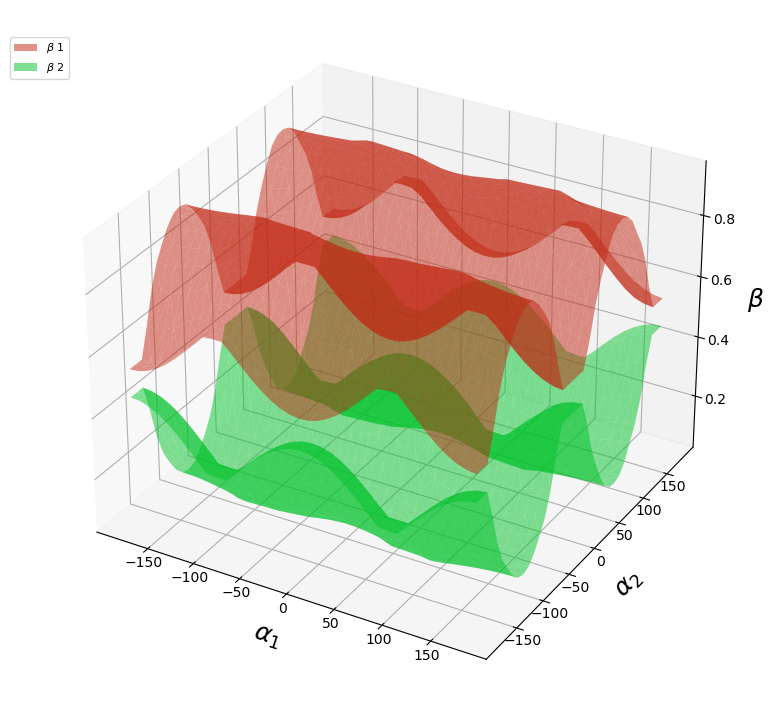

In [16]:
fixed_angle = 'z'
display_angles = show_and_fix_angles[fixed_angle]
d = 2
hyperout =  np.load(f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{d}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_fixed_{fixed_angle}.npy')

mesh = True
show = True
mesh_lib = "matplotlib"
plot_type = "mesh" if mesh else "scatter" 
draw_beta_angle_space(hyperout , 
    dimension=d, 
    display_angles=display_angles, 
    filename=f"plots/beta_alpha{display_angles}_d{d}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_{plot_type}.html", 
    mesh=mesh, 
    show=show, 
    mesh_lib=mesh_lib)

### What about the Beta space when just rotate 1 angle while fixing others? (Not used in the paper)

In [13]:
def compute_HNN_hyper_output(d, x_fixed_degree=None, y_fixed_degree=-180, z_fixed_degree=-90, _step=step):
    # Todo: this function can be merged to function:evaluate_HNN_hyper_out

    model = HyperNetwork(d)
    model = model.to(gpu_computation)

    checkpoint = torch.load(checkpoints_path[d], map_location=gpu_computation)
    model.load_state_dict(checkpoint['state_dict'])

    x_fixed_degree = x_fixed_degree # if none, rotate the object in this axis with sampled degrees by a step defined at the beginning of this notebook
    y_fixed_degree = y_fixed_degree # if value, 
    z_fixed_degree = z_fixed_degree

    hyper_output_path = f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{d}_'
    if x_fixed_degree:
        hyper_output_path += f'X={x_fixed_degree}_'
    else:
        hyper_output_path += f'X_step{_step}_'

    if y_fixed_degree:
        hyper_output_path += f'Y={y_fixed_degree}_'
    else:
        hyper_output_path += f'Y_step{_step}_'

    if z_fixed_degree:
        hyper_output_path += f'Z={z_fixed_degree}_'
    else:
        hyper_output_path += f'Z_step{_step}_'

    hyper_output_path += 'with_angles.npy'
        
    print(hyper_output_path)


    torch.cuda.empty_cache()

    step_x = _step if not x_fixed_degree else 361
    step_y = _step if not y_fixed_degree else 361
    step_z = _step if not z_fixed_degree else 361

    HyperOutput = torch.tensor([]).to(device=gpu_computation)
    with tqdm(range(-180, 181, step_x), position=0) as t:
        for x in t:
            for y in tqdm(range(-180, 181, step_y), disable=True):
                for z in tqdm(range(-180, 181, step_z), disable=True):
                    t.set_description(f'Generate HHN hyper_out')
                    
                    x = x_fixed_degree if x_fixed_degree else x
                    y = y_fixed_degree if y_fixed_degree else y
                    z = z_fixed_degree if z_fixed_degree else z
                    angles = torch.tensor([x,y,z])/180*torch.pi
                    # t1 = time.time()
                    hyper_x = transform_angles(angles=angles).to(device=gpu_computation)
                    hyper_output = model.hyper_stack(hyper_x).detach()
                    hyper_output_with_angles = torch.cat((hyper_output, torch.tensor([x,y,z]).to(gpu_computation)), 0) # with angles
                    hyper_output_with_angles = torch.unsqueeze(hyper_output_with_angles,0)

                    HyperOutput = torch.cat((HyperOutput, hyper_output_with_angles), 0)

                    # t2 = time.time()
                    # print(f'runtime: {t2-t1:>.4}s')
                t.set_postfix(Angles = [x,y,z]) 
                    
    HyperOutput = HyperOutput.cpu().numpy()
    np.save(hyper_output_path, HyperOutput)
    return hyper_output_path

In [45]:
_ = compute_HNN_hyper_output(d=8, x_fixed_degree=None, y_fixed_degree=-180, z_fixed_degree=-90)

./accuracy_result_npy/LeNet5/HHN_hyperout_d_8_X_step10_Y=-180_Z=-90_with_angles.npy


Generate HHN hyper_out: 100%|██████████| 37/37 [00:00<00:00, 646.58it/s, Angles=[180, -180, -90]]


In [20]:
fixed_angle = 'y'
display_angles = show_and_fix_angles[fixed_angle]
d = 8
hyperout =  np.load(hyper_output_path)

mesh = False
show = False
mesh_lib = "matplotlib"
plot_type = "mesh" if mesh else "scatter" 

filename = hyper_output_path.replace("./accuracy_result_npy/LeNet5/HHN_hyperout", f"./plots/beta_alpha{display_angles}" ).replace("with_angles.npy", f"with_angles_{plot_type}.html")
print(filename)

draw_beta_angle_space(hyperout , 
    dimension=d, 
    display_angles=display_angles, 
    filename=filename,
    mesh=mesh, 
    show=show, 
    mesh_lib=mesh_lib)

./plots/beta_alpha[0, 2]_d_8_X_step10_Y=-180_Z=-90_with_angles_scatter.html
Using plotly for 3D scatter


### Draw beta-alpha space for D=[1, 2, 3, 5, 6, 8, 16, 32] respectively (used for the website)

In [19]:

for fa in ['x', 'y', 'z']:
    fixed_angle = fa
    display_angles = show_and_fix_angles[fixed_angle]

    for d in [1, 2, 3, 5, 6, 8, 16, 32]:
        hyperout_d_i_with_angles =  np.load(f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{d}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_fixed_{fixed_angle}.npy')

        mesh = False
        show = False
        mesh_lib = "plotly" #"matplotlib" 

        plot_type = "mesh" if mesh else "scatter" 
        draw_beta_angle_space(hyperout_d_i_with_angles, 
            dimension=d, 
            display_angles=display_angles, 
            filename=f"plots/beta_alpha{display_angles}_d{d}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_{plot_type}.html", 
            mesh=mesh, 
            show=show, 
            mesh_lib=mesh_lib)

Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter


### Draw beta_alpha_sapce plots for paper

<Figure size 640x480 with 0 Axes>

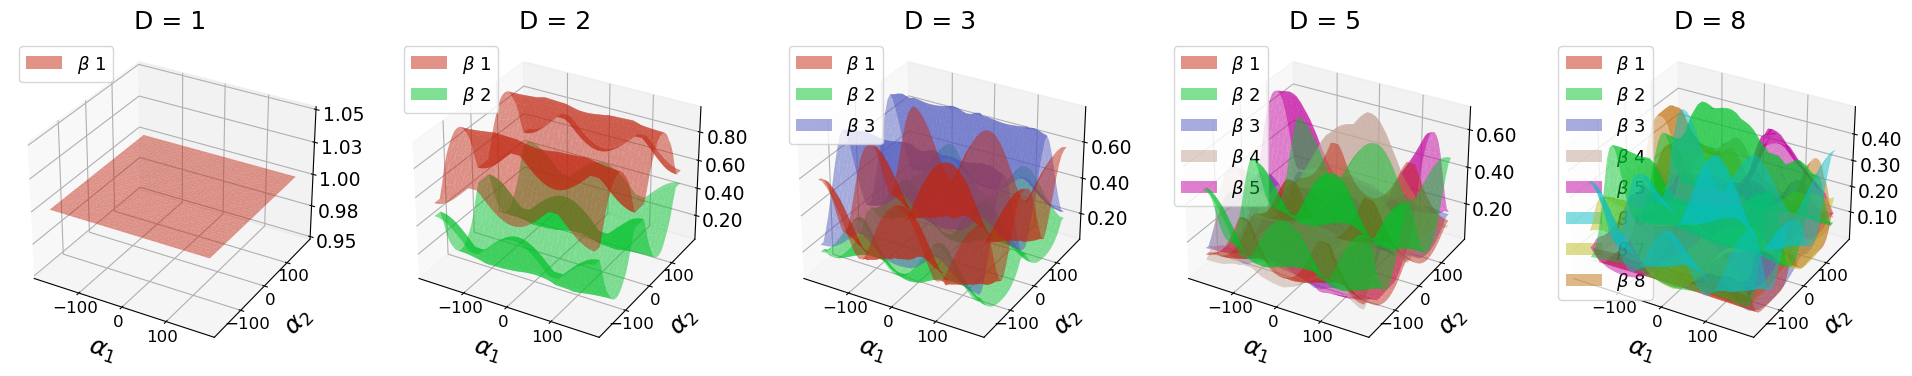

In [12]:
# define color set
pre_defined_colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24

mesh = True
show = False
mesh_lib = "matplotlib" # "plotly"

plot_type = "mesh" if mesh else "scatter" 
fixed_angle = 'z'
display_angles = show_and_fix_angles[fixed_angle]

evaluation_dimensions = [1, 2, 3, 5, 8]#[1, 2, 3, 5, 6, 8, 16, 32]
# num_of_cols = len(evaluation_dimensions)/2
fig = plt.figure()
fig.tight_layout()
# fig, ax = plt.subplots(2, int(len(evaluation_dimensions)/2), subplot_kw={"projection": "3d"},figsize=(24,12))
fig, ax = plt.subplots(1, int(len(evaluation_dimensions)), subplot_kw={"projection": "3d"},figsize=(24,12))

filename=f"plots/beta_alpha{display_angles}_d{evaluation_dimensions}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_{plot_type}.jpg"

for i, dimension in enumerate(evaluation_dimensions):
    hyperout_d_i_with_angles =  np.load(f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{dimension}_X_step{step}_Y_step{step}_Z_step{step}_with_angles_fixed_{fixed_angle}.npy')

    for d in range(dimension):
        color = pre_defined_colors[d]
        # cols = cm.gist_rainbow(np.linspace(0, 1, 32))

        x=hyperout_d_i_with_angles[:, dimension+display_angles[0]] 
        y=hyperout_d_i_with_angles[:, dimension+display_angles[1]]
        z=hyperout_d_i_with_angles[:, d]
        # surf = ax[int(i/num_of_cols)][int(i%num_of_cols)].plot_trisurf(x, y, z,  alpha=0.5, label=r'$\beta$'+f" {d+1}", color=color,  antialiased=True);
        surf = ax[i].plot_trisurf(x, y, z,  alpha=0.5, label=r'$\beta$'+f" {d+1}", color=color,  antialiased=True);

        surf._facecolors2d=surf._facecolors3d # only vaild for matplotlib ~= 3.3.2, invaild for 3.6.2
        surf._edgecolors2d=surf._edgecolors3d # only vaild for matplotlib ~= 3.3.2, invaild for 3.6.2

    ncol_lengend = 1

    # if dimension>5:
    #     ncol_lengend = 2
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].legend(loc="upper left",prop={'size': 8}, ncol=ncol_lengend)
    ## ax[int(i/num_of_cols)][int(i%num_of_cols)].legend(loc=(0, 0.9),prop={'size': 12})
    ax[i].legend(loc="upper left",prop={'size': 13}, ncol=ncol_lengend)

    # ax[int(i/num_of_cols)][int(i%num_of_cols)].set_title(f"D = {dimension}");
    ax[i].set_title(f"D = {dimension}", fontdict={"size":18});

    # ax[i].set_title(f"Beta-Alpha space of HHN-D{dimension} on 3D rotation");

    # ax[int(i/num_of_cols)][int(i%num_of_cols)].tick_params(axis='x', which='major', labelsize=10, pad=-4)
    ax[i].tick_params(axis='x', which='major', labelsize=12, pad=-4)
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].tick_params(axis='y', which='major', labelsize=10, pad=-4)
    ax[i].tick_params(axis='y', which='major', labelsize=12, pad=-4)
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].tick_params(axis='z', which='major', labelsize=10, pad=-1)
    ax[i].tick_params(axis='z', which='major', labelsize=13.5, pad=4)

    ax[i].zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].axes.xaxis.labelpad = 1
    ax[i].axes.xaxis.labelpad = 1
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].axes.yaxis.labelpad = 2
    ax[i].axes.yaxis.labelpad = 2

    ax[i].axes.zaxis.labelpad = 5

    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].set_xlabel(legend_alpha_text[display_angles[0]], fontsize=18)
    ax[i].set_xlabel(legend_alpha_text[display_angles[0]], fontsize=18)
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].set_ylabel(legend_alpha_text[display_angles[1]], fontsize=18)
    ax[i].set_ylabel(legend_alpha_text[display_angles[1]], fontsize=18)
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].zaxis.set_rotate_label(False)
    ax[i].zaxis.set_rotate_label(False)
    
    # ax[int(i/num_of_cols)][int(i%num_of_cols)].set_zlabel(r'$\beta$', fontsize=18, rotation=0)
    # ax[i].set_zlabel(r'$\beta$', fontsize=18, rotation=0)

    # ax[int(i/num_of_cols)][int(i%num_of_cols)].grid(True, linestyle=':')
    ax[i].grid(True, linestyle=':')



plt.savefig(filename, dpi=200,bbox_inches='tight');
if show:
    plt.show();

In [21]:
# copy from evaluate_accuracy_HHN.ipynb and evaluate_accuracy_one4all.ipynb
accuracy_result_dict = {
    "one4one" : 80.62,
    "HHN_D32" : 75.68,
    "HHN_D16" : 75.25,
    "HHN_D8" : 75.02,
    "HHN_D6" : 73.53,
    "HHN_D5" : 67.08,
    "HHN_D3" : 65.01,
    "HHN_D2" : 63.18,
    "HHN_D1" : 56.36,
    "one4all" : 58.93,
    "one4one*" : 15.14, 
}

### Compute the L2-Norm of Beta value for alpha_1 = [-180,-170,..., 170,180], alpha_2 = [-180,-170,..., 170,180], alpha_3 = [-180,-170,..., 170,180]

save to plots/3D_rotation_beta_l2_norm.jpg


<Figure size 1000x1000 with 0 Axes>

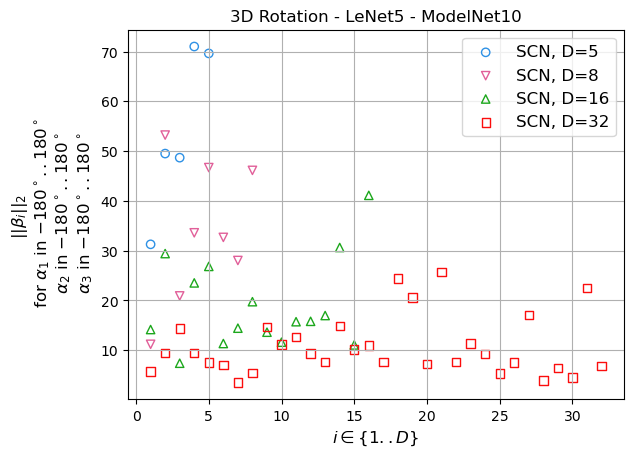

In [225]:
fig = plt.figure(figsize=(10,10))
fig.tight_layout()
fig, ax = plt.subplots()

markers = ["o", "v", "^", "s", "<", ">", "*", "p"]
marker  = iter(markers)
# colors = ['r', 'g', 'b', 'y']

colors = px.colors.qualitative.Dark24[0: len(markers)]
color = iter(colors)

for d in [5,8, 16, 32]:
    hyperout_d_i_with_angles =  np.load(f'./accuracy_result_npy/LeNet5/HHN_hyperout_d_{d}_X_step{step}_Y_step{step}_Z_step{step}_with_angles.npy')
    hyperoutput_d_i = hyperout_d_i_with_angles[:, 0:d] # [0:d] is Beta values, [d:] is degree values
    num_degrees = len(hyperoutput_d_i[:,0])
    x = list(range(1,d+1))
    y = np.linalg.norm(hyperoutput_d_i, axis=0).tolist()
    _label = f'SCN, D={d}'
    ax.scatter(x,y, marker=next(marker), facecolors='none', edgecolors=next(color), label=_label)

    ax.set_xlabel(r'$i\in \{1..D\}$', fontdict={'size':12})
    ax.set_ylabel(r'$||\beta_i||_2$ '+ '\n' + r' for $\alpha_1$ in $-180^\circ..180^\circ$'+ '\n' + r' $\alpha_2$ in $-180^\circ..180^\circ$' + '\n' + r' $\alpha_3$ in $-180^\circ..180^\circ$',fontdict={'size':12})
    ax.set_title(f'3D Rotation - LeNet5 - ModelNet10', fontdict={'size':12})
    ax.legend(loc='upper right',prop={'size': 12})


    ax.grid(True)
filename = f"plots/3D_rotation_beta_l2_norm.jpg"
print(f'save to {filename}')
plt.savefig(filename, dpi=200,bbox_inches='tight');

In [67]:
# d = 16 #[3, 8, 16, 32]

# _hyper_ouput_path_fix_x = compute_HNN_hyper_output(d=d, x_fixed_degree=None, y_fixed_degree=-180, z_fixed_degree=-90, _step=1)
# _hyper_ouput_path_fix_y = compute_HNN_hyper_output(d=d, x_fixed_degree=-90, y_fixed_degree=None, z_fixed_degree=-90, _step=1)
# _hyper_ouput_path_fix_z = compute_HNN_hyper_output(d=d, x_fixed_degree=-90, y_fixed_degree=-180, z_fixed_degree=None, _step=1)



In [68]:
# b = np.load(_hyper_ouput_path_fix_x)[:, 0:3]
# np.linalg.norm(b, axis=0).tolist()


## $\beta$-space of SCNs on 2D transformations （used in website）

### 2D rotation + mlp + FashionMNIST

In [82]:
def path_2d_mlp_scheme(l:int, w:int, d:int):
    return f"./accuracy_result_npy/mlp/hhnmlpb_FashionMNIST_{l}_{w}_{d}/acc.npy"

In [124]:
l, w =1, 32
alpha_1 = np.expand_dims(np.cos(np.array(list(range(360)))/180*np.pi), axis=1)
alpha_2 = np.expand_dims(np.sin(np.array(list(range(360)))/180*np.pi), axis=1)
for d in [1, 2, 3, 5, 8]:
    
    beta_values = pickle.loads(np.load(path_2d_mlp_scheme(l,w,d)))['beta_space']

    hyper_output_with_angles = np.concatenate( (beta_values, alpha_1, alpha_2), axis=1)
    hyper_output_with_angles=hyper_output_with_angles.astype(np.float32)

    mesh = False
    show = False
    mesh_lib = "plotly" # "matplotlib"

    plot_type = "mesh" if mesh else "scatter" 
    draw_beta_angle_space(hyper_output_with_angles, 
        dimension=d, 
        display_angles=display_angles, 
        filename=f"plots/2d/beta_alpha{display_angles}_l_{l}_w_{w}_d{d}_{plot_type}.html", 
        mesh=mesh, 
        show=show, 
        mesh_lib=mesh_lib, mode_3d_scatter="lines")

Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
Using plotly for 3D scatter
